# 🏥 Notebook 2: Computer Vision in Healthcare

In this notebook, you’ll apply what you learned to a real healthcare problem:  
**detecting pneumonia from chest X-ray images**.  

---

## 🎯 Learning Objectives
By the end of this notebook, you will be able to:
1. Prepare medical images (X-rays) for training a deep learning model.  
2. Apply **transfer learning** using ResNet to a healthcare task.  
3. Evaluate model performance and interpret results.  
4. Reflect on the limitations and ethical considerations of AI in medicine.  

---

## 🏥 Why this matters
- Pneumonia is a leading cause of death worldwide.  
- Radiologists often need to examine thousands of X-rays under time pressure.  
- AI models can help **assist diagnosis** by flagging suspicious cases.  

👉 In this notebook, you’ll **train a CNN to detect pneumonia** using chest X-rays.


## 2.0 Load Public Dataset from Kaggle — Chest X-Ray (Pneumonia)

We’ll use the well-known **Chest X-Ray Images (Pneumonia)** dataset from Kaggle.

**What this cell block does:**
1) Authenticates to Kaggle (upload `kaggle.json` once)  
2) Downloads & extracts the dataset  
3) Builds **PyTorch DataLoaders** for train/val/test  


In [ ]:
#@title Install Kaggle CLI + Prepare Auth (one-time per runtime)
!pip -q install kaggle

from google.colab import files, userdata
import os, json, pathlib, shutil

kaggle_key = userdata.get('kaggle_key')

use_manual_upload = False  #@param {type:"boolean"}
# If you prefer to paste creds manually, set use_manual_upload=False and fill below
kaggle_username = "karinhuangsuwan"  # @param {type:"string"}

kaggle_dir = pathlib.Path.home() / ".kaggle"
kaggle_dir.mkdir(exist_ok=True)

if use_manual_upload:
    print("📥 Please upload your kaggle.json (Account > Create New API Token)")
    uploaded = files.upload()
    if "kaggle.json" not in uploaded:
        raise ValueError("kaggle.json not uploaded. Try again.")
    with open(kaggle_dir / "kaggle.json", "wb") as f:
        f.write(uploaded["kaggle.json"])
else:
    if not kaggle_username or not kaggle_key:
        raise ValueError("Fill in kaggle_username and kaggle_key or toggle manual upload.")
    creds = {"username": kaggle_username, "key": kaggle_key}
    with open(kaggle_dir / "kaggle.json", "w") as f:
        json.dump(creds, f)

os.chmod(kaggle_dir / "kaggle.json", 0o600)
print("✅ Kaggle credentials set.")


In [ ]:
#@title Download & Unzip the Chest X-Ray (Pneumonia) Dataset
# Dataset: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
DATA_ROOT = "/content/data"  #@param {type:"string"}

os.makedirs(DATA_ROOT, exist_ok=True)
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p "$DATA_ROOT" -q

zip_path = os.path.join(DATA_ROOT, "chest-xray-pneumonia.zip")
!unzip -q -o "$zip_path" -d "$DATA_ROOT"

# After unzip, structure is: /content/data/chest_xray/{train,val,test}/{NORMAL,PNEUMONIA}
base_dir = os.path.join(DATA_ROOT, "chest_xray")
assert os.path.isdir(base_dir), "Dataset folder chest_xray not found after unzip."
print("✅ Dataset ready at:", base_dir)
!find "$base_dir" -maxdepth 2 -type d -print


## 2.1 Data Preparation

Medical images are often:
- Different sizes (512×512, 1024×1024, etc.)  
- Different intensity ranges (depending on the scanner used)  

We’ll:
1. Resize all images to **224×224**  
2. Convert them to tensors (numerical format)  
3. Normalize pixel values  


In [ ]:
#@title Define Transforms & Build DataLoaders
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms
import numpy as np
import os

#@markdown **Image size:** Resize all images to this square dimension (e.g., 224x224 for ResNet).
img_size = 224  #@param {type:"integer"}

train_tfms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=8),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

eval_tfms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dir = os.path.join(base_dir, "train")
val_dir   = os.path.join(base_dir, "val")
test_dir  = os.path.join(base_dir, "test")

train_ds = datasets.ImageFolder(train_dir, transform=train_tfms)
val_ds   = datasets.ImageFolder(val_dir,   transform=eval_tfms)
test_ds  = datasets.ImageFolder(test_dir,  transform=eval_tfms)

#@markdown **Batch size:** Number of images per batch during training.
batch_size = 32  #@param {type:"integer"}

#@markdown **Number of workers:** Parallel workers for loading data (higher = faster, but more memory usage).
num_workers = 2  #@param {type:"integer"}

# Handle class imbalance with weighted sampler (optional)
targets = np.array([y for _, y in train_ds.samples])
class_counts = np.bincount(targets)
class_weights = 1.0 / class_counts
sample_weights = class_weights[targets]
sampler = WeightedRandomSampler(weights=torch.DoubleTensor(sample_weights),
                                num_samples=len(sample_weights),
                                replacement=True)


In [ ]:
from torch.utils.data import Subset
import random

# fraction of dataset to keep
fraction = 1

def subset_dataset(dataset, fraction):
    n = len(dataset)
    subset_size = int(n * fraction)
    indices = random.sample(range(n), subset_size)
    return Subset(dataset, indices)

train_ds_small = subset_dataset(train_ds, fraction)
val_ds_small   = subset_dataset(val_ds, fraction)
test_ds_small  = subset_dataset(test_ds, fraction)

train_loader = DataLoader(train_ds_small, batch_size=batch_size, sampler=sampler, num_workers=num_workers, pin_memory=True)
val_loader   = DataLoader(val_ds_small, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader  = DataLoader(test_ds_small, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

print("✅ DataLoaders ready.")
print("Classes:", train_ds.classes)
print("Train/Val/Test sizes:", len(train_ds_small), len(val_ds_small), len(test_ds_small))

In [ ]:
#@title Peek at a Few Training Images
import matplotlib.pyplot as plt

def show_batch(dl, n=8):
    xb, yb = next(iter(dl))
    n = min(n, xb.size(0))
    plt.figure(figsize=(12, 3))
    for i in range(n):
        plt.subplot(1, n, i+1)
        # unnormalize for display
        img = xb[i].clone()
        img = img * 0.5 + 0.5
        plt.imshow(img[0].cpu(), cmap="gray")
        plt.axis("off")
        plt.title(train_ds.classes[yb[i].item()])
    plt.show()
#@markdown Adjust the slider to control how many images are shown below.
n = 8  #@param {type:"slider", min:1, max:16, step:1}
show_batch(train_loader, n=n)


## 2.2 Transfer Learning with ResNet

Instead of building a CNN from scratch, we’ll use **ResNet18**,  
pre-trained on ImageNet, and fine-tune it for pneumonia detection.

Why transfer learning?
- Saves compute time  
- Works well with smaller medical datasets  
- Learns general features (edges, textures) and adapts them to X-rays


In [ ]:
#@title Load Pretrained Model
#@markdown Choose which backbone to use for pneumonia classification.
model_name = "ResNet18"  #@param ["ResNet18", "EfficientNet_B0", "DenseNet121"]

import torch.nn as nn
import torchvision.models as models

if model_name == "ResNet18":
    model = models.resnet18(pretrained=True)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 2)

elif model_name == "EfficientNet_B0":
    model = models.efficientnet_b0(pretrained=True)
    num_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_features, 2)

elif model_name == "DenseNet121":
    model = models.densenet121(pretrained=True)
    num_features = model.classifier.in_features
    model.classifier = nn.Linear(num_features, 2)

print(f"✅ {model_name} ready for pneumonia classification!")


## 2.3 Model Training

We’ll fine-tune the model on our dataset.  
This may take a while depending on your dataset size.  

👉 For teaching purposes, we’ll show the training loop structure here.


In [ ]:
#@title Define Training Loop (simplified)

import torch.optim as optim
from tqdm import tqdm  # 👈 Add tqdm

#@markdown **Learning rate (lr):** Controls how big a step the optimizer takes during each update.
#@markdown - Smaller values = slower, but safer convergence
#@markdown - Larger values = faster, but may overshoot or diverge
lr = 0.001 #@param {type:"number"}

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

def train_model(model, train_loader, val_loader, epochs=2):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        # Wrap the loader with tqdm for a progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for images, labels in progress_bar:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            progress_bar.set_postfix(loss=running_loss / (progress_bar.n + 1))

        print(f"Epoch {epoch+1}/{epochs} complete ✅ (lr={lr:.4f})")



In [ ]:
#@title Train/Eval with Your Existing Model & Loops
# Assumes you've already defined:
#   - `model` (e.g., ResNet18 with model.fc = nn.Linear(..., 2))
#   - `train_model(model, train_loader, val_loader, epochs=...)`
#   - `evaluate_model(model, test_loader)` returning (acc, cm)
#@markdown **Number of training epochs:** (how many passes through the dataset)
epochs = 1  #@param {type:"integer"}

print("🏋️ Training...")
train_model(model, train_loader, val_loader, epochs=epochs)


## 2.4 Model Testing & Evaluation

Now let’s test the model on unseen data and check its performance.  

We’ll calculate:
- Accuracy  
- Confusion matrix  
- Example predictions  

👉 In healthcare, evaluation is **critical** — a wrong prediction can mean a missed diagnosis.


In [ ]:
#@title Evaluate the Model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            preds = torch.argmax(outputs, 1)
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())
    acc = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    return acc, cm, all_labels, all_preds


In [ ]:
print("🧪 Testing...")
acc, cm, all_labels, all_preds = evaluate_model(model, test_loader)
print(f"Test Accuracy: {acc:.3f}")
print("Confusion Matrix:\n", cm)

In [ ]:
print(classification_report(all_labels, all_preds))

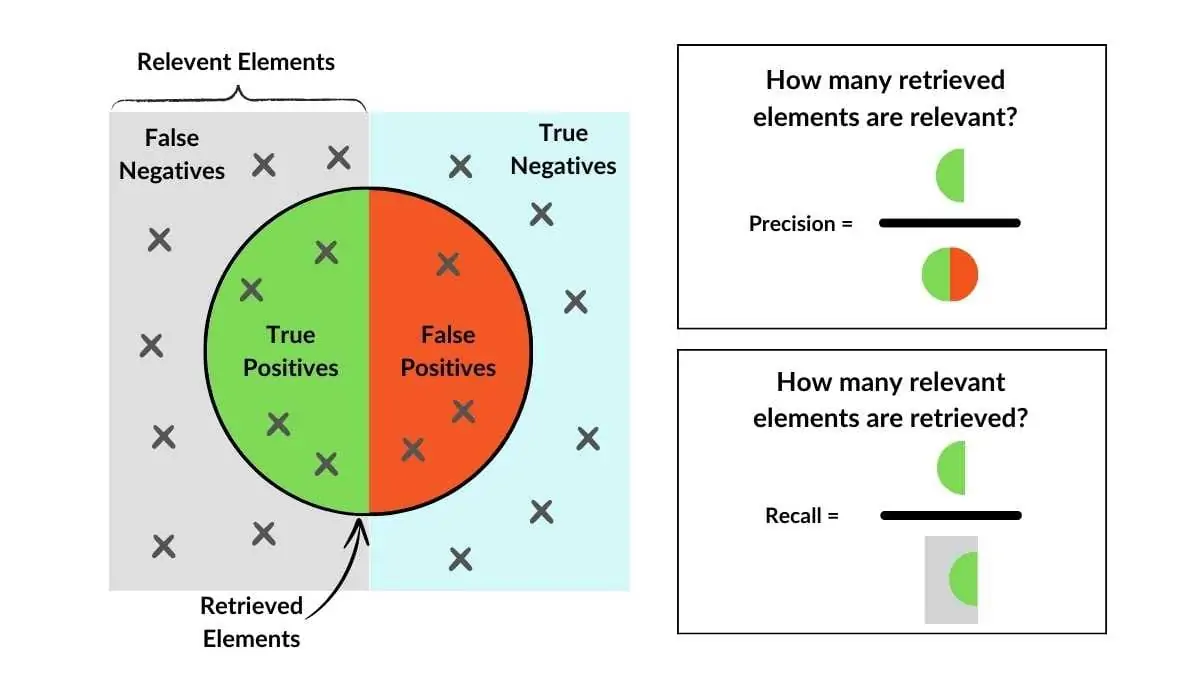

## 2.5 Capstone Project

Now it’s your turn 🚀  

- Train your model on the pneumonia dataset  
- Evaluate its performance  
- Visualize some misclassified cases  

💡 **Challenge:**  
What patterns do you notice in the X-rays that were misclassified?  
Could they confuse even a human radiologist?


# 🌍 Ethics & Limitations

AI in healthcare is powerful but not perfect.  
Consider these questions:
- What are the risks of false negatives in pneumonia detection?  
- How might bias in the dataset (e.g., only one hospital’s patients) affect results?  
- Should AI replace radiologists, or assist them?  

---

✅ Congratulations! You’ve built your first medical AI pipeline.  
In the next notebook, we’ll explore **federated learning** to train across hospitals without sharing patient data.
